### Imports & Data Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 (enables 3-D plots)
import seaborn as sns
import time
from scipy.stats import multivariate_normal

In [2]:
# Load TMNIST CSV (labels column + 784 pixel columns)
df = pd.read_csv('tmnst Dataset.csv')
labels = df.iloc[:, 0].astype(str).values
print(labels)
df.head()

['D' 'F' 'J' ... 'N' 'J' 'I']


,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,H,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.iloc[:, 1:].values.astype(np.float32)
print('X shape:', X.shape)
print('X dtype:', X.dtype)
print('X min:', X.min())
print('X max:', X.max())
print('X mean:', X.mean())
print('X std:', X.std())

X shape: (74724, 784)
X dtype: float32
X min: 0.0
X max: 255.0
X mean: 36.31008
X std: 79.75607


In [4]:
X = (X-0) / (255.0-0)   # max-min normalise to [0,1] range
print('X shape:', X.shape)
print('X dtype:', X.dtype)
print('X min:', X.min())
print('X max:', X.max())
print('X mean:', X.mean())
print('X std:', X.std())

X shape: (74724, 784)
X dtype: float32
X min: 0.0
X max: 1.0
X mean: 0.14239249
X std: 0.3127689


In [5]:
classes = sorted(np.unique(labels))
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, stratify=labels, train_size=0.7, random_state=42) #split 70-30 for train and test

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52306, 784), (22418, 784), (52306,), (22418,))

---
### Problem 1 — PCA vs. Fisher (3-D)

In [6]:
def pca_vs_fisher_3d(X_train, y_train, selected_classes):
    """
    Draws side-by-side 3-D scatter plots: PCA (left) and Fisher LDA (right).
    selected_classes – list of exactly 4 labels to compare.
    """
    # Select the data points for the specified classes
    idx = np.isin(y_train, selected_classes)
    X_sel, y_sel = X_train[idx], y_train[idx]

    # Compute PCA and LDA projections
    pca = PCA(n_components=len(selected_classes)-1).fit_transform(X_sel, y_sel)
    lda = LDA(n_components=len(selected_classes)-1).fit_transform(X_sel, y_sel)

    # Create the figure with two 3D subplots
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the data points for each class
    colors = ['r','g','b','c']
    for cls, col in zip(selected_classes, colors):
        mask = y_sel == cls
        ax1.scatter(*pca[mask].T, c=col, label=cls)
        ax2.scatter(*lda[mask].T, c=col, label=cls)

    # Set the titles and legends
    ax1.set_title('PCA Projection')
    ax2.set_title('Fisher Projection')
    for ax in (ax1, ax2):
        ax.legend()

    # Show the plot
    plt.show()

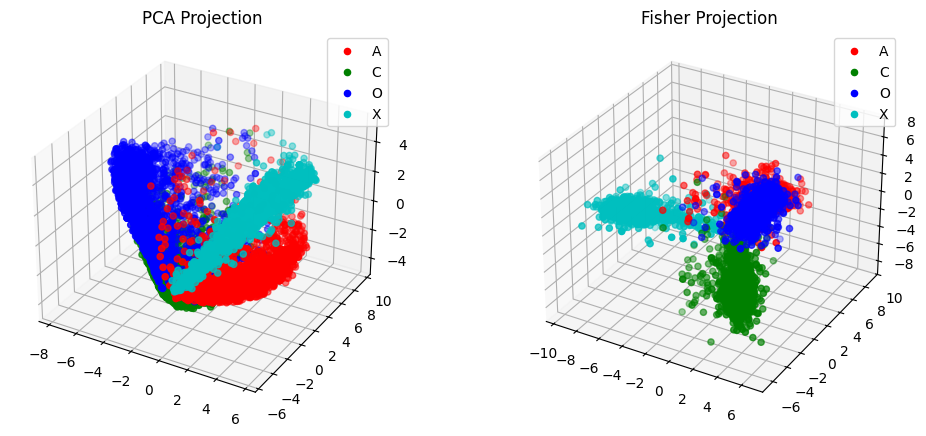

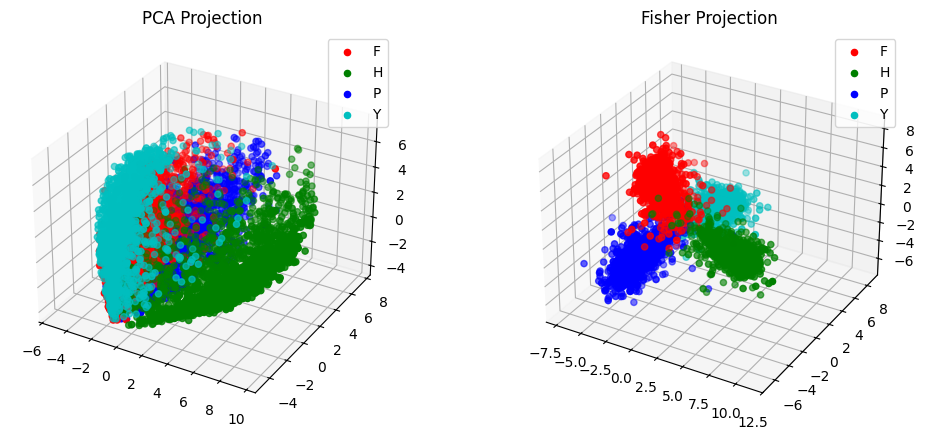

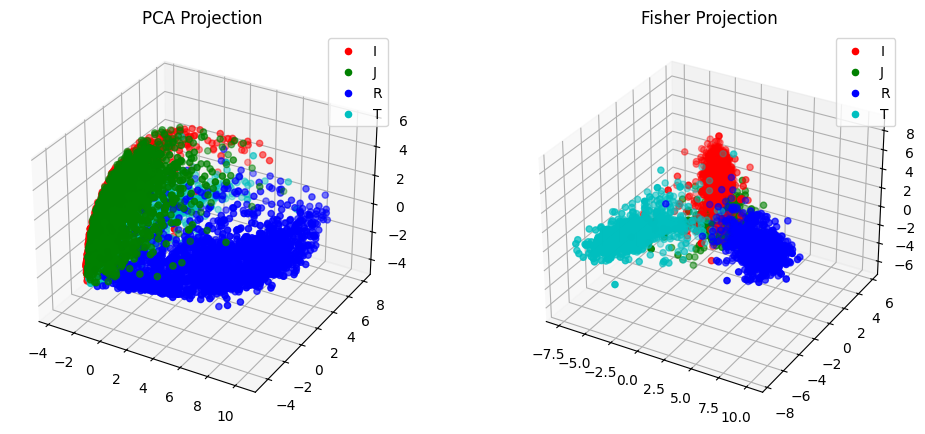

In [7]:
# Generate the six required plots (3 combos of 4 classes each)
# Each combo is a list of the 4 class labels to be plotted together
combos = [
    ['A','C','O','X'], # ABCO
    ['F','H','P','Y'], # FHYP
    ['I','J','R','T']  # IJRT
]
for combo in combos:
    # Plot the 3D scatter plot of PCA vs Fisher
    pca_vs_fisher_3d(X_train, y_train, combo)


When we look at the projections for PCA dn Fischer we can see 
1. 4 components are getting only 2 projection planes in PCA but they are getting 3 distinct projections planes in Fischer
2. PCA mainly focus on the maximization of variance, so similar looking letter are getting projected close to each other, where as in Fisher we maximizing class seperations and hence lower loss of data 
Ex 
1. IN PCA C and O are getting projected close to each other where are Fisher we see clear seperation
2. Similarly for R and T in [I, J, R, T] subclass 

---
### Problem 2 — Fisher Distance Matrix + MDS

In [8]:
# Compute Fisher score for every pair of classes
# This is a measure of how well the classes are separated
# by a linear projection
pairs = []
for i, c1 in enumerate(classes):
    for c2 in classes[i+1:]:
        idx = np.isin(y_train, [c1, c2])
        X_pair, y_pair = X_train[idx], y_train[idx]
        try:
            # Compute LDA on the subset of data
            lda = LDA(n_components=1) # class of 2 will have 1 projection component
            X_proj = lda.fit_transform(X_pair, y_pair)
            # Compute the variance of the projected data
            # and divide it by the variance of the original data
            # to get the Fisher score
            score = np.var(X_proj) / np.var(X_pair)
        except Exception:
            score = 0
        pairs.append((c1, c2, score))
fisher_df = pd.DataFrame(pairs, columns=['Class 1','Class 2','Fisher Discriminant scores'])
fisher_df.to_csv('fisher_scores.csv', index=False)
fisher_df.head()

,Class 1,Class 2,Fisher Discriminant scores
0,A,B,197.920090
1,A,C,227.361984
2,A,D,186.706558
3,A,E,211.859314
4,A,F,219.735168


In [9]:
# Most similar 5 classes from Class 'A'
fisher_df[fisher_df['Class 1']=='A'].sort_values('Fisher Discriminant scores', ascending=False).head()

,Class 1,Class 2,Fisher Discriminant scores
7,A,I,316.039154
18,A,T,294.124786
10,A,L,279.390594
24,A,Z,268.779022
22,A,X,251.801300


In [10]:
# Bottom 5 similar classes from Class 'A' i.e they are far apart
fisher_df[fisher_df['Class 1']=='A'].sort_values('Fisher Discriminant scores', ascending=True).head()

,Class 1,Class 2,Fisher Discriminant scores
16,A,R,114.881508
5,A,G,152.503876
12,A,N,153.046478
9,A,K,158.058502
6,A,H,161.176682


When looking at the Fisher Discriminant Analysis for Letter A again all other leters, we can see that the 
1. I, T, L, Z and X are the letters that are least distingushable from A class the Highest FD score (Similarity)
2. R, G, N, K, H are the letter that are well seperated to Letter A as they have the least FD score (Similarity)

Similarly the scores is calculated for all the Letter against other remaing letters.

In [11]:
fisher_df['Class 1'].value_counts()

Class 1
A    25
B    24
C    23
D    22
E    21
F    20
G    19
H    18
I    17
J    16
K    15
L    14
M    13
N    12
O    11
P    10
Q     9
R     8
S     7
T     6
U     5
V     4
W     3
X     2
Y     1
Name: count, dtype: int64

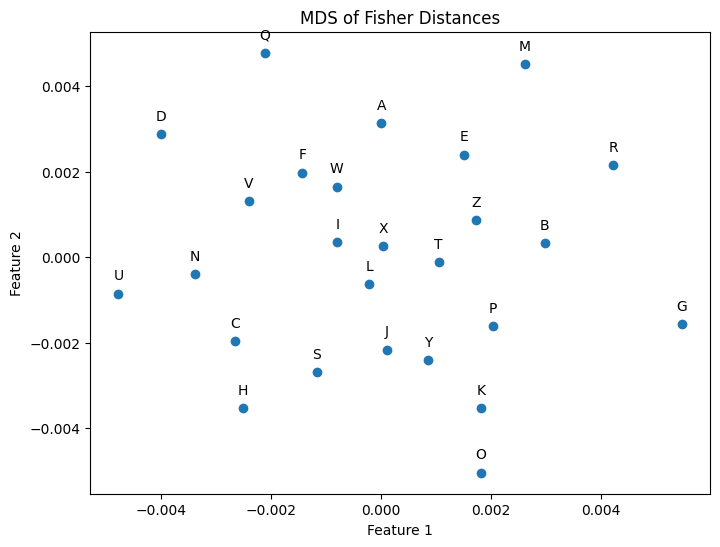

In [12]:
# Build a distance matrix from the similarity scores
# The distance matrix is needed for MDS, and it's computed as follows:
#  - The distance between two characters is the inverse of their similarity score
#    (smaller similarity scores mean larger distances)
dist = np.zeros((26, 26))
# Iterate over all pairs (c1, c2, s)
for c1, c2, s in pairs:
    # Get the indices of the two characters in the classes list
    i, j = classes.index(c1), classes.index(c2)
    # Invert the similarity score to get a distance
    dist[i, j] = dist[j, i] = 1.0 / (s + 1e-6) # 1e-6 is a small number to avoid division by zero

# Create an MDS object with 2 components, using the precomputed distance matrix
# The `dissimilarity='precomputed'` parameter tells MDS to use the precomputed
# distance matrix, instead of computing a new one from the data.
# P.S. Took help on this from GenAI
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
# Fit the MDS object to the distance matrix
# This will compute the 2D coordinates of all characters
coords = mds.fit_transform(dist) 

# Plot the 2D coordinates of all characters
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1])
# Add labels to each character
for i, c in enumerate(classes):
    plt.annotate(f'{c}',
                 xy=(coords[i,0], coords[i,1]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.title(f'MDS of Fisher Distances')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Similar to distance score, MDS plot based on Distance (1/Similarity metric Fischer Discriminant Score), we get 
1. I, T, L, Z and X are the letters that are Closer to A
2. R, G, N, K, H are the letter that are far apart to Letter A

---
### Problem 3 — KNN & Parzen Sweeps (25-D Fisher space)

In [13]:
# Fit LDA model to training data
lda_all = LDA(n_components=25).fit(X_train, y_train)

# Transform training and test data using LDA and saving the same into a new Datafame
Xtr_lda = lda_all.transform(X_train) 
Xte_lda = lda_all.transform(X_test)

Xtr_lda.shape, Xte_lda.shape

((52306, 25), (22418, 25))

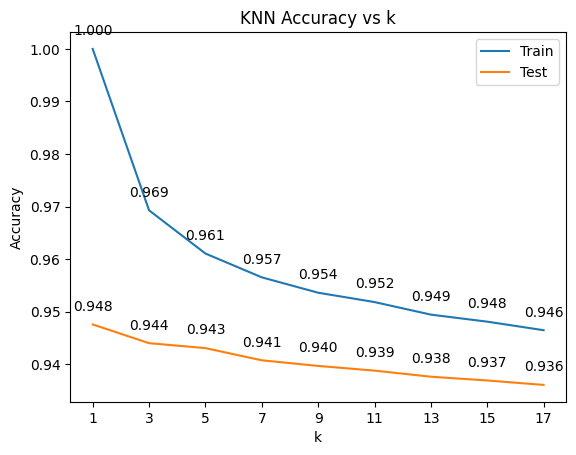

In [14]:
# K-NN sweep
# loop over k values, train a KNN model and store its performance
k_list = [1,3,5,7,9,11,13,15,17]
knn_res = []
for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k).fit(Xtr_lda, y_train)
    # store training and test accuracy
    knn_res.append((k, clf.score(Xtr_lda, y_train), clf.score(Xte_lda, y_test)))
# convert to a dataframe for easier plotting
knn_df = pd.DataFrame(knn_res, columns=['k','Train Accuracy','Test Accuracy'])

# save to csv for later use
knn_df.to_csv('Knn.csv', index=False)

# plot train and test accuracy
sns.lineplot(data=knn_df, x='k', y='Train Accuracy', label='Train')
sns.lineplot(data=knn_df, x='k', y='Test Accuracy', label='Test')
plt.title('KNN Accuracy vs k')
plt.xticks(knn_df['k'])
plt.ylabel('Accuracy')
for index, row in knn_df.iterrows():
    plt.annotate(
        f"{row['Train Accuracy']:.3f}",
        (row['k'], row['Train Accuracy']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    plt.annotate(
        f"{row['Test Accuracy']:.3f}",
        (row['k'], row['Test Accuracy']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
plt.show()

Time taken for sigma=0.1: 80.02551698684692 seconds
Time taken for sigma=0.5: 98.1108968257904 seconds
Time taken for sigma=1: 86.64810085296631 seconds
Time taken for sigma=1.5: 115.35921287536621 seconds
Time taken for sigma=2: 127.84215712547302 seconds
Time taken for sigma=3: 105.42909002304077 seconds
Time taken for sigma=4: 106.40153002738953 seconds
Time taken for sigma=6: 81.16881203651428 seconds
Time taken for sigma=8: 82.90286016464233 seconds
Time taken for sigma=10: 81.30304622650146 seconds


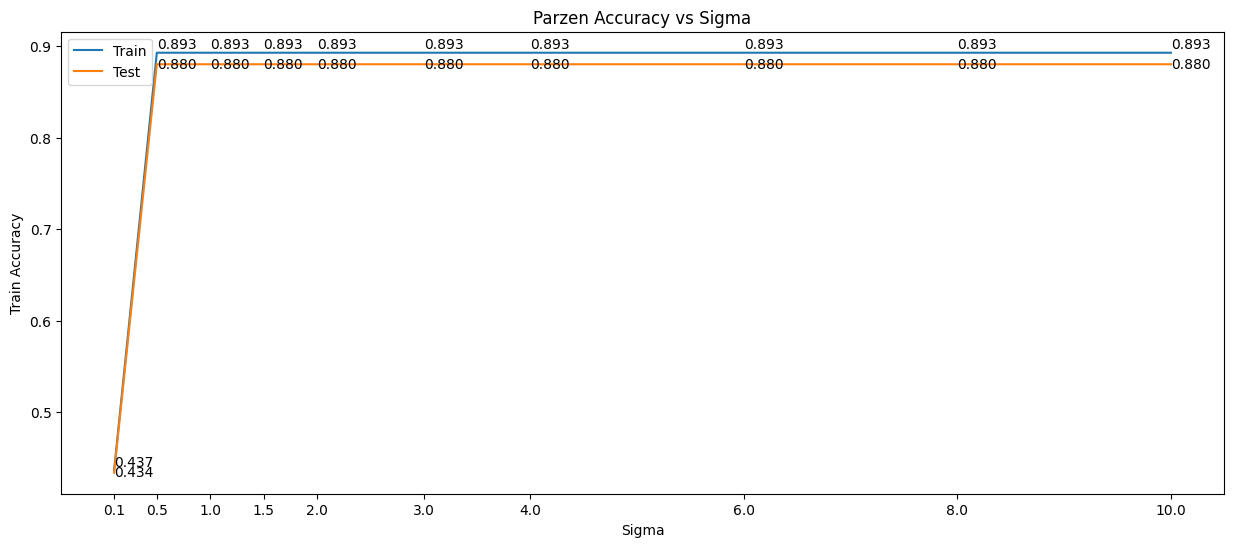

In [ ]:
# Parzen window sweep
def parzen_predict(train_x, train_y, test_x, sigma):
    # Get unique labels from training data
    labels = np.unique(train_y)

    # Initialize predictions array
    preds = []
    
    # Loop over each test sample
    for tx in test_x:
        # Initialize scores array
        scores = []

        # Loop over each class
        for lbl in labels:
            # Get subset of training data for current class
            cls_data = train_x[train_y == lbl]
            
            # Compute Parzen window density estimate for current class
            # using multivariate_normal.pdf()
            p = multivariate_normal(cls_data.mean(axis=0), sigma**2 * np.eye(train_x.shape[1])).pdf(tx)
            
            # Append score to scores array
            scores.append(p)
        
        # Append prediction to predictions array
        preds.append(labels[np.argmax(scores)])
    
    # Return predictions array
    return np.array(preds)

# List of values for Sigma to try
sigma_list = [0.1,0.5,1,1.5,2,3,4,6,8,10]

# Initialize results array
parzen_res = []

# Used smaller subset here to optimize for run time
# but use a larger subset of training data to get better accuracy if compute power is available
sub_tr = 5000
# 2000 ~ Runtime 6min 14s @ 0.87 Max Accuracy 
# 5000 ~ Runtime 15min 18s @ 0.88 Max Accuracy *** use this for final results ***
# 8000 ~ Runtime 45min 47s @ 0.88 Max Accuracy 
# 10000 ~ Runtime 33min 54s @ 0.88 Max Accuracy

# Loop over each value of SIGMA
for s in sigma_list:
    start = time.time()
    # Compute predictions on training data
    yhat_tr = parzen_predict(Xtr_lda[:sub_tr], y_train[:sub_tr], Xtr_lda[:sub_tr], s)
    
    # Compute predictions on test data
    yhat_te = parzen_predict(Xtr_lda[:sub_tr], y_train[:sub_tr], Xte_lda[:500], s)
    end = time.time()
    print(f"Time taken for sigma={s}: {end-start} seconds")
    
    # Append results to results array
    parzen_res.append((s, accuracy_score(y_train[:sub_tr], yhat_tr), accuracy_score(y_test[:500], yhat_te)))

# Convert results array to DataFrame
parzen_df = pd.DataFrame(parzen_res, columns=['Sigma','Train Accuracy','Test Accuracy'])

# Save results to CSV file
parzen_df.to_csv('Parzen.csv', index=False)

# Plot results
plt.figure(figsize=(15,6))
sns.lineplot(data=parzen_df, x='Sigma', y='Train Accuracy', label='Train')
sns.lineplot(data=parzen_df, x='Sigma', y='Test Accuracy', label='Test')
plt.xticks(sigma_list)
plt.title('Parzen Accuracy vs Sigma')
# Add annotations
for i, row in parzen_df.iterrows():
    plt.annotate(
        f'{row["Train Accuracy"]:.3f}',
        (row["Sigma"], row["Train Accuracy"]),
        xytext=(0, 3),
        textcoords='offset points'
    )
    plt.annotate(
        f'{row["Test Accuracy"]:.3f}',
        (row["Sigma"], row["Test Accuracy"]),
        xytext=(0, -3),
        textcoords='offset points'
    )
plt.show()

### K-NN Method

* With 70% of the data as Training in Knn Method we are getting at ~ 0.94 accuracy in test data
	+ Knn Accuracy Plateaus at ~0.94 with increasing the K neighbours Hyperparameter

### Parzen Window Classifier

* with only 5000 rows as Training sample we are getting 0.89 accuracy in test data
	+ Sample Size plays a key role in getting good training and test accuracy in Parzen Window Classifier
	+ We get below Accuracy with Test data based on Sample Sizes
		- 2000 ~ 6min 14s @ 0.87 Max Accuracy 
        - 5000 ~ 15min 18s @ 0.88 Max Accuracy *** use this for final results ***
        - 8000 ~ 45min 47s @ 0.88 Max Accuracy 
        - 10000 ~ 33min 54s @ 0.88 Max Accuracy

---
### Problem 4 — Perceptron vs Logistic Regression (100 runs)

In [16]:
# select two classes for binary classification
cls_pair = ['A','C']

# create mask for training and test data
mask_tr = np.isin(y_train, cls_pair)
mask_te = np.isin(y_test, cls_pair)

# select data for binary classification
Xtr_bin, ytr_bin = Xtr_lda[mask_tr], y_train[mask_tr]
Xte_bin, yte_bin = Xte_lda[mask_te], y_test[mask_te]

In [17]:
def multi_run(model_fn, runs=100):
    res = []
    for i in range(runs):
        # create a new model
        clf = model_fn()
        # sample a bootstrap
        idx_boot = np.random.choice(len(Xtr_bin), size=len(Xtr_bin), replace=True)
        X_boot = Xtr_bin[idx_boot, :]
        y_boot = ytr_bin[idx_boot]
        # fit the model
        clf.fit(X_boot, y_boot)
        # record the performance metrics
        res.append((i, clf.score(X_boot, y_boot), clf.score(Xte_bin, yte_bin)))
    return pd.DataFrame(res, columns=['Run','Train Acc','Test Acc'])

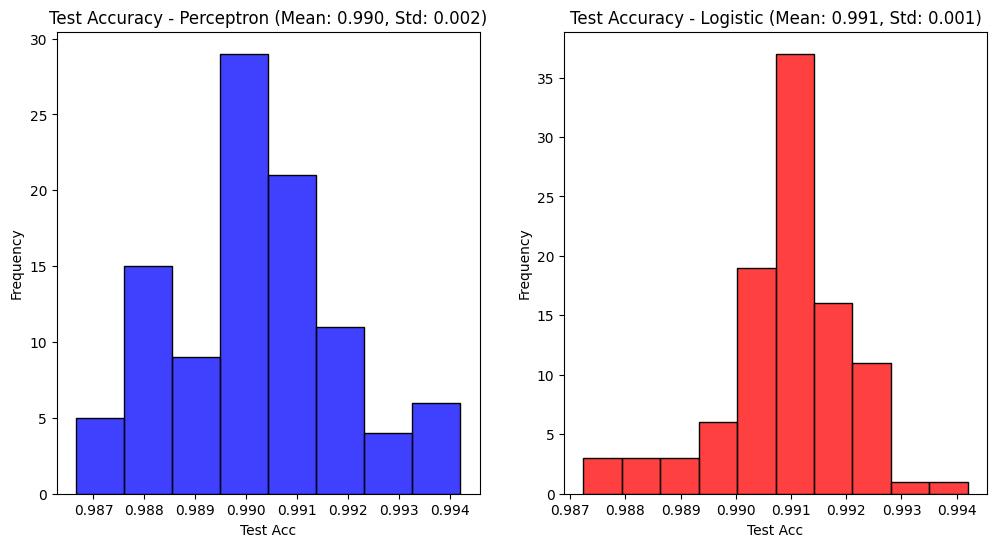

In [18]:
# Run multiple times to get a sense of the mean performance of the
# two models. Each run trains a model on the binary data and
# evaluates its performance on the test set.
per_df = multi_run(lambda: Perceptron(max_iter=2000))
log_df = multi_run(lambda: LogisticRegression(max_iter=2000))

# Save the results to CSVs, so we can load them later
per_df.to_csv('perceptron_A_C.csv', index=False)
log_df.to_csv('logistic_A_C.csv', index=False)

# Plot the histogram of the test accuracy for both models
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(per_df['Test Acc'], ax=ax[0], color='b', kde=False)
sns.histplot(log_df['Test Acc'], ax=ax[1], color='r', kde=False)
ax[0].set_title(f'Test Accuracy - Perceptron (Mean: {per_df["Test Acc"].mean():.3f}, Std: {per_df["Test Acc"].std():.3f})')
ax[1].set_title(f'Test Accuracy - Logistic (Mean: {log_df["Test Acc"].mean():.3f}, Std: {log_df["Test Acc"].std():.3f})')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
plt.show()


We get similar Acurracy in both the methods @ 0.99 with std of ~0.001 on multiple sample runs